In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import PIL.Image as Image

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
# !sudo pip3 install requests -U

Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (2.22.0)


## `grace hopper`

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_RES = 224

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

Let's get an image and try to predict using this model. We also need to resize it (that's specified in the blog) and convert into numpy array (not specified?).

In [4]:
grace_hopper = Image.open('grace_hopper.jpg')

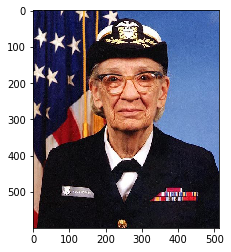

In [5]:
plt.imshow(grace_hopper);

In [6]:
grace_hopper.size

(512, 600)

In [7]:
grace_hopper = grace_hopper.resize((IMAGE_RES, IMAGE_RES))

In [8]:
grace_hopper.size

(224, 224)

In [9]:
grace_hopper_arr = np.array(grace_hopper) / 255.

In [10]:
grace_hopper_arr.shape

(224, 224, 3)

In [11]:
grace_hopper_arr_batch = np.expand_dims(grace_hopper_arr, axis=0)

In [12]:
grace_hopper_arr_batch.shape

(1, 224, 224, 3)

Now we may use our model to predict a class (both a class index and its name). And we get a correct answer: `military uniform`.

In [13]:
result = model.predict(grace_hopper_arr_batch)

In [14]:
result.shape

(1, 1001)

In [15]:
predicted_class = np.argmax(result[0])

In [16]:
predicted_class

653

In [17]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

16384/10484 [==============================================] - 0s 0us/step


In [18]:
labels_path

'/home/ilyarudyak/.keras/datasets/ImageNetLabels.txt'

In [19]:
labels = open(labels_path).read().splitlines()

In [20]:
labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [21]:
labels[653]

'military uniform'

## cats and dogs - prediction

### get data

So `tfds` are `tf` datasets. We may load them using `load`:

> with_info: bool, if True, tfds.load will return the tuple (tf.data.Dataset, tfds.core.DatasetInfo) containing the info associated with the builder.

> as_supervised: bool, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned tf.data.Dataset will have a dictionary with all the features.

Splits are not quite clear but it looks like that we're getting all the data (`train, val and test`) and somehow weighting `val` data.

In [23]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

In [24]:
train_examples, validation_examples = splits

In [25]:
train_examples

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [26]:
num_examples = info.splits['train'].num_examples

In [27]:
num_examples

23262

In [28]:
num_classes = info.features['label'].num_classes

In [29]:
num_classes

2

In [30]:
for image, label in train_examples.take(3):
    print(image.shape, label)

(500, 343, 3) tf.Tensor(1, shape=(), dtype=int64)
(375, 500, 3) tf.Tensor(0, shape=(), dtype=int64)
(375, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


It looks like this is a number of all examples, not only training examples.

In [31]:
len(list(train_examples))

18622

In [32]:
len(list(validation_examples))

4640

In [33]:
18622 + 4640

23262

In [34]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

In [35]:
BATCH_SIZE = 32

In [36]:
train_batches = train_examples \
                    .shuffle(num_examples//4) \
                    .map(format_image) \
                    .batch(BATCH_SIZE) \
                    .prefetch(1)

In [37]:
# no shuffling for val images
validation_batches = validation_examples \
                        .map(format_image) \
                        .batch(BATCH_SIZE) \
                        .prefetch(1)

### predict using our model

In [38]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [39]:
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32,))

In [40]:
result_batch = model.predict(image_batch)

In [41]:
result_batch.shape

(32, 1001)

In [42]:
imagenet_labels = np.array(labels)

In [43]:
imagenet_labels.shape

(1001,)

In [44]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

In [45]:
predicted_class_names.shape

(32,)

In [46]:
predicted_class_names[:5]

array(['Labrador retriever', 'American Staffordshire terrier', 'redbone',
       'basset', 'dingo'], dtype='<U30')

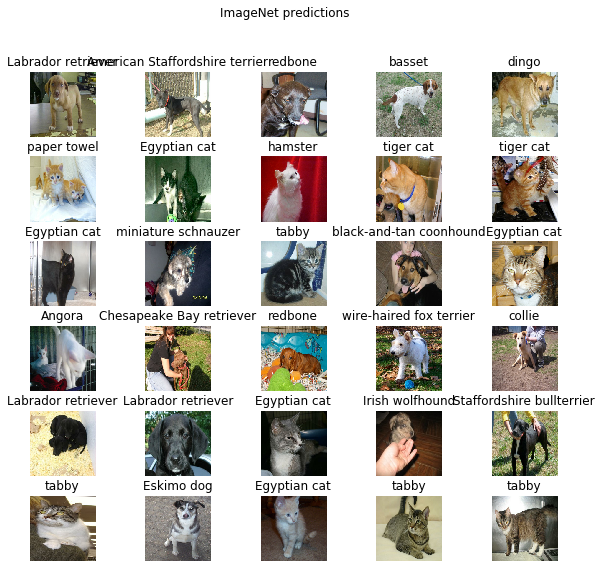

In [47]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## cats and dogs - transfer learning

In [48]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [49]:
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [50]:
feature_batch = feature_extractor(image_batch)

In [51]:
feature_batch.shape

TensorShape([32, 1280])

In [52]:
feature_extractor.trainable = False

In [53]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax')
])

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [55]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [56]:
EPOCHS = 6

In [57]:
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 37s 63ms/step - loss: 0.0621 - accuracy: 0.9774 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 27s 46ms/step - loss: 0.0301 - accuracy: 0.9896 - val_loss: 0.0539 - val_accuracy: 0.9823
Epoch 3/6
582/582 [==============================] - 26s 45ms/step - loss: 0.0253 - accuracy: 0.9914 - val_loss: 0.0300 - val_accuracy: 0.9879
Epoch 4/6
582/582 [==============================] - 26s 45ms/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.0327 - val_accuracy: 0.9881
Epoch 5/6
582/582 [==============================] - 26s 45ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0313 - val_accuracy: 0.9892
Epoch 6/6
582/582 [==============================] - 26s 45ms/step - loss: 0.0176 - accuracy: 0.9943 - val_loss: 0.0354 - val_accuracy: 0.9879


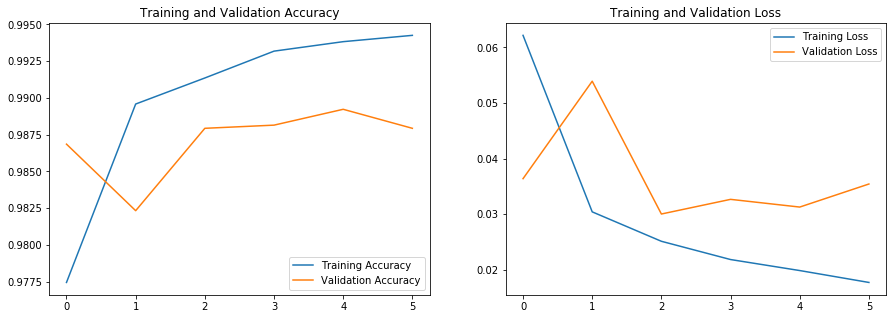

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [69]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat',
       'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog',
       'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog',
       'cat', 'cat', 'cat', 'dog', 'dog'], dtype='<U3')

In [70]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1]
Predicted labels:  [1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1]


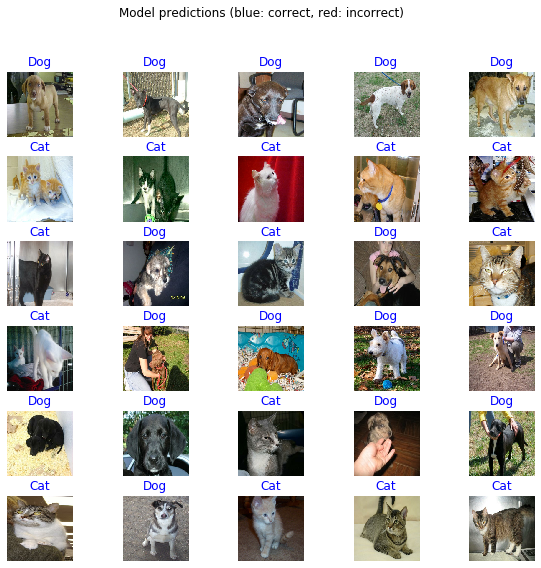

In [71]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")